# **Number classification algorithm**

# Read database

Functions used to read the database (train and test) from MNIST and also from the csv file generated with the images captured from the pico camera

In [28]:
import create_database as cdb
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import itertools

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import RandomizedSearchCV
from sklearn.grid_search import GridSearchCV

In [3]:
%%time

cdb.main(0.8)

test.csvfile does not exist, creating one!

Creating data base with photos taken...

Data base for number 1 created
Data base for number 2 created
Data base for number 3 created
Data base for number 4 created
Data base for number 5 created
Data base for number 6 created

Data base created

Removing training_database.csv

Removing testing_database.csv

Creating training and testing database randomly...
Percentage of the trainningset: 0.8
Percentage of the trainningset: 0.2

Removing test.csv

Training and testing database created

CPU times: user 190 ms, sys: 9.04 ms, total: 199 ms
Wall time: 197 ms


In [4]:
class Digit:
    def __init__(self, data, target):
        self.target = target
        self.width  = int(np.sqrt(len(data)))
        self.image  = data.reshape(self.width, self.width)
        self.features = {'var' : 0,
                         'std' : 0,
                         'mean_grad_M' : 0,
                         'std_grad_M'  : 0,
                         'mean_grad_D' : 0,
                         'std_grad_D'  : 0,
                         'mean_PC_X'   : 0,
                         'std_PC_X'    : 0,
                         'active_PC_X' : 0,
                         'mean_PC_Y'   : 0,
                         'std_PC_Y'    : 0,
                         'active_PC_Y' : 0}
        self.computeFeatures()
    
    def computeFeatures(self):
        # Feature computation
        mag, ang = sobel(self.image)
        pcx, pcy = pixel_count(self.image)
        
        self.features['var'] = np.var(self.image)
        self.features['std'] = np.std(self.image)
        self.features['mean_grad_M'] = np.mean(mag)
        self.features['std_grad_M'] =  np.std(mag)
        self.features['mean_grad_D'] = np.mean(ang)
        self.features['std_grad_D'] =  np.std(ang)
        self.features['mean_PC_X'] =   np.mean(pcx)
        self.features['std_PC_X'] =    np.std(pcx)
        self.features['active_PC_X'] = np.count_nonzero(pcx)
        self.features['mean_PC_Y'] =   np.mean(pcy)
        self.features['std_PC_Y'] =    np.std(pcy)
        self.features['active_PC_Y'] = np.count_nonzero(pcy) 
  
    def __print__(self):
        print("Digit target: "+str(self.target))
        print("Digit features:")
        print(self.features)
        print("Digit image:")
        plt.gray()
        plt.matshow(self.image) 
        plt.show()

In [5]:
def sobel(image):
    w = len(image)
    kernel_x = np.array([ [ 1, 0,-1],
                          [ 2, 0,-2],
                          [ 1, 0,-1] ])

    kernel_y = np.array([ [ 1, 2, 1],
                          [ 0, 0, 0],
                          [-1,-2,-1] ])
    
    grad_x = np.zeros([w - 2, w - 2])
    grad_y = np.zeros([w - 2, w - 2])
    
    for i in range(w - 2):
        for j in range(w - 2):
            grad_x[i, j] = sum(sum(image[i : i + 3, j : j + 3] * kernel_x))
            grad_y[i, j] = sum(sum(image[i : i + 3, j : j + 3] * kernel_y))
            if grad_x[i, j] == 0:
                grad_x[i, j] = 0.000001 
    
    mag = np.sqrt(grad_y ** 2 + grad_x ** 2)
    ang = np.arctan(grad_y / (grad_x + np.finfo(float).eps))
  
    # Gradient computation
  
    return [mag,ang]

def pixel_count(image):
    pc_x = np.zeros(len(image))
    pc_y = np.zeros(len(image))
  
    # Pixel count computation
    for i in range(len(image)):
        pc_x[i] = np.count_nonzero(image[i, :])
        pc_y[i] = np.count_nonzero(image[:, i])

    return [pc_x, pc_y]

In [6]:
class Dataset:
    def __init__(self, filename, length):  
        self.filename = filename
        if length == -1:
            with open(self.filename, 'r') as csvfile:
                spamreader = csv.reader(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_NONNUMERIC) 
                self.length = sum(1 for row in spamreader)
        else: 
            self.length = length
            self.digits = []
        self.digits = self.createDigits()
        self.raw_features = [[float(f) for f in dig.features.values()] for dig in self.digits]
        self.raw_targets  = [[self.digits[i].target] for i in range(self.length)]
  
    def createDigits(self):
        # Parse the csv file row by row and create Digits on the fly
        digits = []
        with open(self.filename, 'r') as csvfile:
            spamreader = csv.reader(csvfile, delimiter = ',', quotechar = '|', quoting = csv.QUOTE_NONNUMERIC)
            for i, row in enumerate(spamreader):
                if i == self.length: break
                digits.append(Digit(np.array(row[:-1]), row[-1]))
                
        return digits

In [46]:
# n1 : percent of the number of lines in the data base use as training set
# n2 : percent of the number of lines in the data base use as testing set
def load_data_sets(n1, n2):
    
    print("Creating training set")
    with open(os.getcwd() + "/training_database.csv") as f:
        lines = sum(1 for line in f)
        print("Number of the lines in the database: " + str(lines)) 

    print("Number of the lines in the training set: "+ str(int(n1*lines)))
    training_set = Dataset(os.getcwd() + "/training_database.csv",int(n1*lines))

    print("\nCreating testing set")
    with open(os.getcwd() + "/testing_database.csv") as f:
        lines = sum(1 for line in f)
        print("Number of the lines in the database: " + str(lines))

    print ("Number of the lines in the database: " + str(int(n2*lines)))
    testing_set = Dataset(os.getcwd() + "/testing_database.csv", int(n2*lines))

    print ("\nFinished creating datasets\n")
    
    return training_set, testing_set

In [47]:
%%time
training_set, testing_set = load_data_sets(1, 1)

Creating training set
Number of the lines in the database: 33
Number of the lines in the training set: 33

Creating testing set
Number of the lines in the database: 7
Number of the lines in the database: 7

Finished creating datasets

CPU times: user 476 ms, sys: 5.26 ms, total: 481 ms
Wall time: 474 ms


In [15]:
def cvt_obj_nparray(dataset):
    X = np.zeros((dataset.length, 12))
    Y = np.zeros((dataset.length,))
    for i, digit in enumerate(dataset.digits):
        Y[i] = digit.target
        for j, feature in enumerate(digit.features):
            X[i, j] = digit.features[feature]
    return X, Y

X_train, Y_train = cvt_obj_nparray(training_set)
X_test, Y_test = cvt_obj_nparray(testing_set)

# **KK Neighborhod algorithm**

In [16]:
def plot_confusion_matrix(clf, data_x, data_y):
    classes = ['1', '2', '3', '4', '5', '6']

    Ypred = clf.predict(data_x)
    
    # Computation of confusion matrix on testing set
    cm = confusion_matrix(data_y, Ypred)
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [19]:
def train_knnModel(i):  
    #Train the classifier
    print("Training KNN classifier...")
    clf = KNeighborsClassifier(n_neighbors=i)
    print("Finished trainning KNN classifier with " + str(i) + " neighbors")
    
    # Training KNN
    return clf.fit(X_train, Y_train)

knn_classificator = train_knnModel(5)

Training KNN classifier
Finished trainning KNN classifier with 5 neighbors


The accuracy for test database is: 36.364%
Using: 33 images


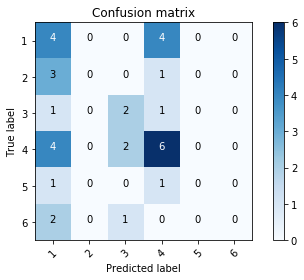

In [29]:
# Compute prediction accuracy on training set
def train_knnModel2():
    predicted = knn_classificator.predict(X_train)
    print("The accuracy for test database is: " + str(round((accuracy_score(Y_train, predicted) * 100), 3)) + "%")

    print("Using: " + str(len(X_train)) + " images")
    
    plot_confusion_matrix(knn_classificator, X_train, Y_train)
    plt.show()

train_knnModel2()

The accuracy for test database is: 28.571%
Using: 7 images


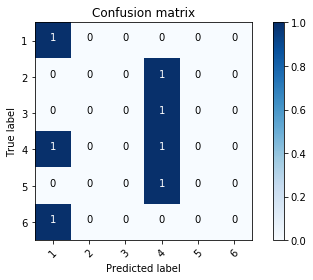

In [30]:
# Compute prediction accuracy on testing set
def test_knnModel():
    predicted = knn_classificator.predict(X_test)
    print("The accuracy for test database is: " + str(round((accuracy_score(Y_test, predicted) * 100), 3)) + "%")

    print("Using: " + str(len(X_test)) + " images")
    
    plot_confusion_matrix(knn_classificator, X_test, Y_test)
    plt.show()

test_knnModel()

# **Evaluation methods**

This part contains the functions used to analyse the accuracy of the classifier

# **Multiple Hyperparameter Study**
This part consist in making a study of the hyperparameter of the classifier, using the gridsearch method from the scikitlearn library.

In [35]:
# Define the parameter values that should be searched
k_range = list(range(1, 5))

# Another parameter besides k that we might vary is the weights parameters or even the algorithm
weight_options = ['uniform', 'distance']
#algorithm_options = ['auto', 'ball_tree', 'kd_tree', 'brute']

# Specify "parameter grid"
param_grid = dict(n_neighbors=k_range, weights=weight_options)

# Specify "parameter distributions" rather than a "parameter grid"
param_dist = dict(n_neighbors=k_range, weights=weight_options)

# Since both parameters are discrete, so param_dist is the same as param_grid

# Finally define the classifier, in this case the KNN classifier
knn = KNeighborsClassifier()

In [37]:
%%time

grid_best_scores = []
grid_best_params = []
grid_best_estimator = []

rand_best_scores = []
rand_best_params = []
rand_best_estimator = []

for _ in list(range(20)):
    grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', n_jobs = -1)
    grid.fit(X_train, Y_train)
    grid_best_scores.append(grid.best_score_)
    grid_best_params.append(grid.best_params_)
    grid_best_estimator.append(grid.best_estimator_)

    rand = RandomizedSearchCV(knn, param_dist, cv=10, scoring='accuracy', n_iter=5, n_jobs = -1)
    rand.fit(X_train, Y_train)
    rand_best_scores.append(rand.best_score_)
    rand_best_params.append(rand.best_params_)
    rand_best_estimator.append(rand.best_estimator_)
    
print("Finished searching the hyper parameters!")


Finished searching the hyper parameters!
CPU times: user 5.31 s, sys: 1.4 s, total: 6.71 s
Wall time: 10.7 s


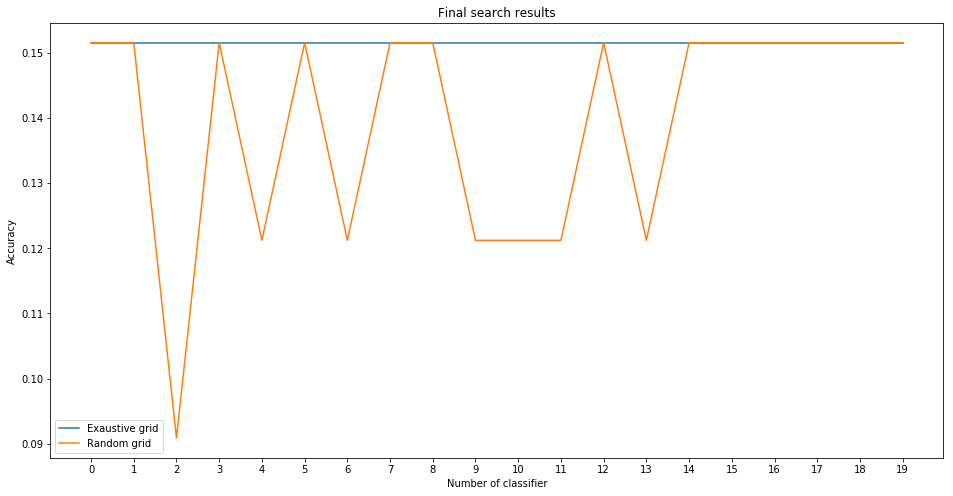

GRID SEARCH RESULTS
The best accuracy is: 15.1515151515%
The parameters is: {'n_neighbors': 4, 'weights': 'uniform'}


RANDOMGRID SEARCH RESULTS
The best accuracy is: 15.1515151515%
The parameters is: {'n_neighbors': 4, 'weights': 'uniform'}


In [38]:
# This block draw accuracies of the differents classifiers used in the grid and random search

plt.figure(figsize=(16, 8))
plt.title("Final search results")   
plt.plot(range(len(grid_best_scores)), grid_best_scores, label = 'Exaustive grid')
plt.plot(range(len(rand_best_scores)), rand_best_scores, label = 'Random grid')
plt.xlabel('Number of classifier')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(range(len(grid_best_scores)))
plt.show()

print("GRID SEARCH RESULTS")
print("The best accuracy is: " + str(np.max(grid_best_scores) * 100) + "%")
print("The parameters is: " + str(grid_best_params[np.argmax(grid_best_scores)]))
print('\n')
print("RANDOMGRID SEARCH RESULTS")
print("The best accuracy is: " + str(np.max(rand_best_scores) * 100) + "%")
print("The parameters is: " + str(rand_best_params[np.argmax(rand_best_scores)]))

# Best KNN classificator

In [42]:
#Train the best classificator for a N sample of numbers
def train_best_classifier():   
    classificator = rand_best_estimator[np.argmax(rand_best_scores)]

    return classificator.fit(X_train, Y_train)

In [43]:
#Testing this new classificator accuracy with MNIST database 
def test_database(clf):
    predicted = clf.predict(X_test)
    
    print("The accuracy for MNIST test database is: " + str(round((accuracy_score(Y_test, predicted) * 100), 3)) + "%")
    print("Using: " + str(len(X_train)) + " images to train")
    print("Using: " + str(len(X_test)) + " images in the test")

    plot_confusion_matrix(clf, X_test, Y_test)



In [44]:
best_knn_classificator = train_best_classifier()

The accuracy for MNIST test database is: 28.571%
Using: 33 images to train
Using: 7 images in the test


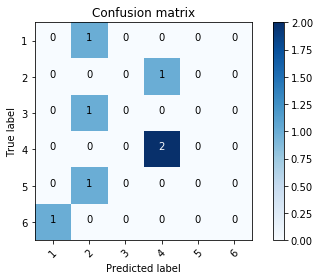

In [45]:
test_database(best_knn_classificator)

In [26]:
importance = opt_clf.feature_importances_
print(importance)

AttributeError: 'KNeighborsClassifier' object has no attribute 'feature_importances_'

In [ ]:
bins = np.arange(len(training_set.digits[0].features))
label_list = []
for feature in training_set.digits[0].features:
    label_list.append(feature)

plt.figure(figsize=(16,4))
ax = plt.subplot(111)
ax.bar(bins, importance)
ax.set_xticks(np.arange(len(label_list)))
ax.set_yticks([])
ax.set_xticklabels(label_list, rotation = 45, ha = 'right')
# Display bar graph of feature importances with feature names as labels